In [26]:
import sys
sys.path.append('/host/d/Github/')
import SimpleITK as sitk
import glob
import os
import glob
import lpips
import torch
import numpy as np
import pandas as pd
import nibabel as nb
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt


import Diffusion_denoising_thin_slice.functions_collection as ff
import Diffusion_denoising_thin_slice.Build_lists.Build_list as Build_list

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
build_sheet =  Build_list.Build(os.path.join('/host/d/Data/low_dose_CT/Patient_lists/mayo_low_dose_CT_gaussian_simulation_v2.xlsx'))
batch_list, patient_id_list, random_num_list,noise_file_all_list, noise_file_odd_list, noise_file_even_list, ground_truth_file_list, slice_num_list = build_sheet.__build__(batch_list = ['test']) 
n = ff.get_X_numbers_in_interval(total_number = patient_id_list.shape[0],start_number = 0,end_number = 1, interval = 1)

In [35]:
def calc_mae_with_ref_window(img, ref, vmin, vmax):
    maes = []
    for slice_num in range(0, img.shape[-1]):
        slice_img = img[:,:,slice_num]
        slice_ref = ref[:,:,slice_num]
        mask = np.where((slice_ref >= vmin) & (slice_ref <= vmax), 1, 0)
        mae = np.sum(np.abs(slice_img - slice_ref) * mask) / np.sum(mask)
        maes.append(mae)

    return np.mean(maes), np.std(maes)

def calc_ssim_with_ref_window(img, ref, vmin, vmax):

    ssims = []
    for slice_num in range(0, img.shape[-1]):
        slice_img = img[:,:,slice_num]
        slice_ref = ref[:,:,slice_num]
        mask = np.where((slice_ref >= vmin) & (slice_ref <= vmax), 1, 0)
        _, ssim_map = structural_similarity(slice_img, slice_ref, data_range=vmax - vmin, full=True)
        ssim = np.sum(ssim_map * mask) / np.sum(mask)
        ssims.append(ssim)

    return np.mean(ssims), np.std(ssims)

def calc_lpips(imgs1, imgs2, vmin, vmax):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    loss_fn = lpips.LPIPS().to(device)
    
    lpipss = []
    for slice_num in range(0, imgs1.shape[-1]):
        slice1 = imgs1[:,:,slice_num]
        slice2 = imgs2[:,:,slice_num]

        slice1 = np.clip(slice1, vmin, vmax).astype(np.float32)
        slice2 = np.clip(slice2, vmin, vmax).astype(np.float32)

        slice1 = (slice1 - vmin) / (vmax - vmin) * 2 - 1
        slice2 = (slice2 - vmin) / (vmax - vmin) * 2 - 1

        slice1 = np.stack([slice1, slice1, slice1], axis=-1)
        slice2 = np.stack([slice2, slice2, slice2], axis=-1)
        # print('after stack, slice1 shape:', slice1.shape, ' slice2 shape:', slice2.shape)

        slice1 = np.transpose(slice1, (2, 0, 1))[np.newaxis, ...]
        slice2 = np.transpose(slice2, (2, 0, 1))[np.newaxis, ...]
        # print('after transpose, slice1 shape:', slice1.shape, ' slice2 shape:', slice2.shape)

        slice1 = torch.from_numpy(slice1).to(device)
        slice2 = torch.from_numpy(slice2).to(device)

        lpips_val = loss_fn(slice1, slice2)
        lpipss.append(lpips_val.item())

      

    return np.mean(lpipss), np.std(lpipss)


# get metrics curve according to number of inferences

In [36]:
num_inferences = [1, 2,6,10,14,20]

mae_list = []
ssim_list = []

for i in range(0, len(num_inferences)):
    n_infer = num_inferences[i]
    print(f'Number of inferences: {n_infer}')

    mae_for_this_infer = []
    ssim_for_this_infer = []

    for j in range(0, len(n)):

        patient_id = patient_id_list[n[j]]
        random_n = random_num_list[n[j]]
        print(patient_id,  random_n)

        # reference image
        gt_file = os.path.join('/host/d/Data/low_dose_CT/nii_imgs', patient_id,  'img.nii.gz')
        gt_img = nb.load(gt_file).get_fdata()[...,100:200]

        # # our method 
        if n_infer != 1:
            unsupervised_beta0_avg_file = os.path.join('/host/d/projects/denoising/models/unsupervised_gaussian_2/pred_images_input_both', patient_id,'random_'+str(random_n), 'epoch190avg/pred_img_scans' + str(n_infer) + '.nii.gz')
            unsupervised_beta0_avg_img = nb.load(unsupervised_beta0_avg_file).get_fdata()
        else:
            unsupervised_beta0_avg_file = os.path.join('/host/d/projects/denoising/models/unsupervised_gaussian_2/pred_images_input_both', patient_id,'random_'+str(random_n), 'epoch190_1/pred_img.nii.gz')
            unsupervised_beta0_avg_img = nb.load(unsupervised_beta0_avg_file).get_fdata()

        vmin = -200
        vmax = 250
        mae_case,_= calc_mae_with_ref_window(unsupervised_beta0_avg_img, gt_img, vmin, vmax)
        ssim_case, _ = calc_ssim_with_ref_window(unsupervised_beta0_avg_img, gt_img, vmin, vmax)
        print(f'MAE: {mae_case}, SSIM: {ssim_case}')

        mae_for_this_infer.append(mae_case)
        ssim_for_this_infer.append(ssim_case)
    print('mae for this inference:', mae_for_this_infer, 'ssim for this inference:', ssim_for_this_infer)

    mae_list.append(np.mean(mae_for_this_infer))
    ssim_list.append(np.mean(ssim_for_this_infer))



Number of inferences: 1
L192 0
MAE: 15.149918487933201, SSIM: 0.6665754238493904
L143 0
MAE: 15.749167726561826, SSIM: 0.656029028536794
L291 0
MAE: 18.37763703990255, SSIM: 0.6306835588206352
mae for this inference: [15.149918487933201, 15.749167726561826, 18.37763703990255] ssim for this inference: [0.6665754238493904, 0.656029028536794, 0.6306835588206352]
Number of inferences: 2
L192 0
MAE: 12.9024864630264, SSIM: 0.7225383470642776
L143 0
MAE: 13.774321442294747, SSIM: 0.7023389873805372
L291 0
MAE: 15.873792706770391, SSIM: 0.6844331870118932
mae for this inference: [12.9024864630264, 13.774321442294747, 15.873792706770391] ssim for this inference: [0.7225383470642776, 0.7023389873805372, 0.6844331870118932]
Number of inferences: 6
L192 0
MAE: 11.135928345418922, SSIM: 0.7697207589515923
L143 0
MAE: 12.267540691601711, SSIM: 0.7397651761048027
L291 0
MAE: 13.942534251188826, SSIM: 0.7295841590737395
mae for this inference: [11.135928345418922, 12.267540691601711, 13.9425342511888

In [38]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

for power law, the limit of y when x is very large is: 11.75970405973759


<Figure size 800x600 with 0 Axes>

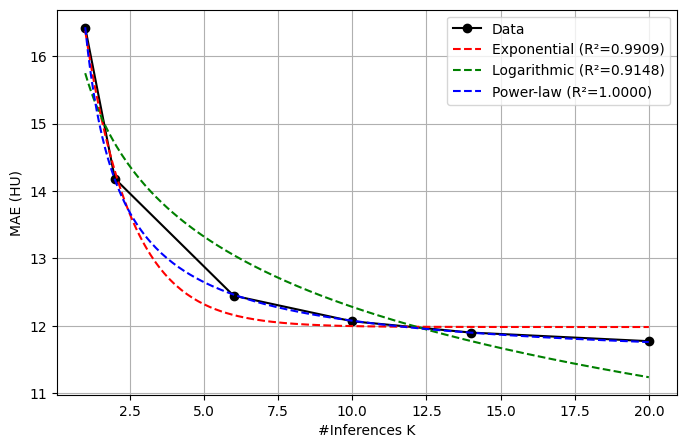

In [41]:
plt.figure(figsize=(4, 3), dpi=200)
# using plt.errorbar to show error bars
x = np.asarray(num_inferences)
y = np.asarray(mae_list)

# Define fitting functions
def log_func(x, a, b):
    return a * np.log(x) + b

def power_func(x, a, b, c):
    return a * x**(-b) + c

def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit the curves
popt_log, _ = curve_fit(log_func, x, y)
popt_pow, _ = curve_fit(power_func, x, y, maxfev=10000)
popt_exp, _ = curve_fit(exp_func, x, y, maxfev=10000)

# Generate predictions
x_fit = np.linspace(1, 20, 200)
y_log = log_func(x_fit, *popt_log)
y_pow = power_func(x_fit, *popt_pow)
y_exp = exp_func(x_fit, *popt_exp)

# Calculate R^2
r2_exp = r2_score(y, exp_func(x, *popt_exp))
r2_log = r2_score(y, log_func(x, *popt_log))
r2_pow = r2_score(y, power_func(x, *popt_pow))

# find the limit of y when x is very large
y_limit_pow = power_func(20, *popt_pow)
print('for power law, the limit of y when x is very large is:', y_limit_pow)

plt.figure(figsize=(8, 5))
plt.plot(x, y, 'ko-', label='Data')
plt.plot(x_fit, y_exp, 'r--', label=f'Exponential (R²={r2_exp:.4f})')
plt.plot(x_fit, y_log, 'g--', label=f'Logarithmic (R²={r2_log:.4f})')
plt.plot(x_fit, y_pow, 'b--', label=f'Power-law (R²={r2_pow:.4f})')

plt.xlabel('#Inferences K')
plt.ylabel('MAE (HU)')
plt.grid()
plt.legend()